In [1]:
#!pip install mat73==0.41
#!pip install seaborn==0.11.0
#!pip install sklearn

In [2]:
%matplotlib inline

import mat73
import glob
import numpy as np
import matplotlib.pyplot as plt
import sys
import math
from scipy.stats import *
from scipy.optimize import curve_fit 
from cmath import phase
from numpy import array
from scipy.stats import circmean,circvar,circstd
from matplotlib.pylab import *
from sklearn.linear_model import LinearRegression
import pandas as pd
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split




In [3]:
# circstats
def len2(x):
	if type(x) is not type([]):
		if type(x) is not type(array([])):
			return -1
	return len(x)

def phase2(x):
	if not np.isnan(x):
		return phase(x)
	return np.nan

def circdist(angles1,angles2):
    if len2(angles2) < 0:
        if len2(angles1) > 0:
            angles2 = [angles2]*len(angles1)
        else:
            angles2 = [angles2]
            angles1 = [angles1]
        if len2(angles1) < 0:
            angles1 = [angles1]*len(angles2)
    return array(list(map(lambda a1,a2: phase2(np.exp(1j*a1)/np.exp(1j*a2)), angles1,angles2)))

In [4]:
def convert_visdeg2deg2(alpha_x, alpha_y, screen_len):
    '''
    Converts angles of visual degree to angles on circle on screen 

    Parameters
    ----------
    alpha_x : list of array of x-Angle in visual degree 
    alpha_y : list of array of y-Angle in visual degree 
    screen_len : distance between screen and subject

    Returns
    -------
    alpha_full: list of arrays of Angle on working-memory circle in [°] for all sessions for one monkey

    '''
    # calculate tan of each array in list
    x = [np.tan(i) * screen_len for i in alpha_x]#screen_len*np.tan(alpha_x) # convert visual degree to coordinates
    y = [np.tan(i) * screen_len for i in alpha_y]#screen_len*np.tan(alpha_y)
    print(len(x))
    alpha_full = x
    #print(len(x))
    # convert coordinates to angle along circle as in classical WM tasks (0° at top, clockwise)
    for i in range(0,len(x)):# for each session
        # tangens only goes from 0-180, change to 0-360
        idx = np.where(np.logical_or(np.logical_and(x[i]>0, y[i]>0), np.logical_and(x[i]>0, y[i]<0)))
        alpha_full[i][idx] = [0.5*np.pi-np.arctan(y[i][k]/x[i][k]) for k in idx]
        idx = np.where(np.logical_or(np.logical_and(x[i]<0, y[i]<0), np.logical_and(x[i]<0, y[i]>0)))
        alpha_full[i][idx] = [1.5*np.pi-np.arctan(y[i][k]/x[i][k]) for k in idx]
    return [i*180/np.pi for i in alpha_full]

### Load data

In [71]:
monkey = []
session = []
full_idx = []
idx_len = []
trial_idx = []
full_rf = []
Counts= []
InFEF= []
ROIs = []
TargetAngle = []
targ_loc = ([],[])
SacAngle = []
neuronData = []
spikeTimes = []
spikeClusters = []
spikeNeurons = []
full_time=[]
t_fix_start = ([])
t_trial_start = ([])
t_delay_start = ([])
t_delay_end = ([])
t_trial_end = ([])
stim_offset = ([])
t_trial_starttimePLX = ([])
t_trial_starttime = ([])
t_targOn_start = ([])
t_saccade = ([])
t_complete = ([])
t_lastFrame = ([])
for m in ["a","l"]:
    files = np.sort(glob.glob("../Data/%s*.mat" % m))
    for fl in files[0:1]:#[0]:#files:#
        data_dict = mat73.loadmat(fl)#mat73.loadmat('../Data/a20170517_1230.mat')#
        sess = 0
        # GENERAL INFORMATION
        idx=data_dict["data"]["trialParams"]["goodtrial"]# completed trials  
        full_idx.append(np.asarray(idx))
        idx_len.append(len(idx))
        trial_idx.append(np.where(idx==True)[0]) # index of good trials 
        mon = [m for i in range(len(np.where(idx==True)[0]))] # save which monkey
        monkey.append(mon)
        session.append(np.ones(len(np.where(idx==True)[0]), dtype=int)*sess)# save which session
        sess += 1
        full_rf.append(data_dict["data"]["trialParams"]["rfSide"][np.where(idx==True)])# receptive field in/out
        Counts.append(len(data_dict['data']['ROIs'])) # how many regions of interest
        InFEF.append(np.sum(np.array(data_dict['data']['ROIs']) == 'FEF'))# how many FEF 
        ROI_temp = data_dict['data']['ROIs']
        ROIs.append(ROI_temp)

        # BEHAVIORAL INFORMATION
        TarXY = data_dict["data"]["trialParams"]["targXY"][np.where(idx==True)]# target position in degrees of visual angle
        TargetAngle.append(TarXY)
        SacXY = data_dict["data"]["trialParams"]["endEyePosXY"][np.where(idx==True)]# saccade end position (response) in degrees of visual angle
        SacAngle.append(SacXY)

        # NEURAL INFORMATION
        binnedSess = []
        for i in range(0,len(data_dict['data']['ROIs'])): # for each neuron
            if len(data_dict['data']['ROIs'])==1: # cannot iterate when only one neuron recorded
                binnedSess.append(data_dict["data"]["unit"]["trialStart"]['binnedArray'])# list of binned spikedata (trials x time) for each session seperated by recorded neuron
            else:
                binnedSess.append(data_dict["data"]["unit"]["trialStart"][i]['binnedArray'])# list of binned spikedata (trials x time) for each session seperated by recorded neuron
        neuronData.append(binnedSess)
        # raw data
        spikeTimes.append(data_dict['data']['spikeData']['spikeTimes'])# time of spiking event (pre-trial sorting)
        spikeClusters.append(data_dict['data']['spikeData']['postSortCl']) # evaluated neuron clusters
        spikeNeurons.append(data_dict['data']['spikeData']['clusters']) # to which neuron cluster a spike belongs
        
        
        
        # TIMING
        full_time.append(data_dict['data']['trialParams']['trialEvents']['trialStartTimePLX'][np.where(idx==True)])
        #t_trial_starttime.append(data_dict["data"]["trialParams"]["trialEvents"]["trialStartTime"])# official start time (for sanity check)
        t_fix_start.append(data_dict["data"]["trialParams"]["trialEvents"]["timeFpOn"][np.where(idx==True)])
        t_trial_start.append(data_dict["data"]["trialParams"]["trialEvents"]["timeFpEntered"][np.where(idx==True)])# monkey entered fixation
        t_targOn_start.append(data_dict["data"]["trialParams"]["trialEvents"]["timeTargetOn"][np.where(idx==True)]) # target on + 200ms = target off = delay start
        t_delay_start.append(data_dict["data"]["trialParams"]["trialEvents"]["timeTargetOn"][np.where(idx==True)]+0.2) #
        t_delay_end.append(data_dict["data"]["trialParams"]["trialEvents"]["timeFpOff"][np.where(idx==True)]) # fixation turned off (GO cue)
        t_saccade.append(data_dict["data"]["trialParams"]["trialEvents"]["saccadeTime"][np.where(idx==True)])
        t_trial_end.append(data_dict["data"]["trialParams"]["trialEvents"]["trialEnd"][np.where(idx==True)])
        print(fl)

../Data/a20170331_1347.mat
../Data/l20181017_1125.mat


## Data alignment

In [172]:
bins = 1000000# PLEXON bins in microseconds
a=0
for sess in range(len(spikeClusters)):
    for trial_num, trial_start in enumerate(full_time[sess][:-1]): # for each trial, plexon trial starttime
        bool_inTrial = (spikeTimes[sess]>trial_start)&(spikeTimes[sess]<full_time[sess][trial_num+1]) # create bool for which spikes are in viewed trial
        if np.where(bool_inTrial)[0].shape[0]==0:
            a+=1
        else:
            time_inTrial = (np.round((spikeTimes[sess][bool_inTrial]-min(spikeTimes[sess][bool_inTrial]))*bins)).astype(int)# align trial start time to 0, create indices
            #spikeMatrix_trial = csr_matrix((len(spikeClusters[sess]), max(time_inTrial)+1))# create array (neurons x time bins)
            row_timeNeuron=[]
            col_idxNeuron=[]
            data=[]
            for neuron,cluster in enumerate(spikeClusters[sess]):# for each neurons cluster ID
                row_timeNeuron.append(time_inTrial[spikeNeurons[sess][bool_inTrial]==cluster])# determine spikes that belong to each neuron
                col_idxNeuron.append(np.ones(len(row_timeNeuron[neuron]), dtype=int)*neuron) # determine columns of sparse matrix (neuron index)
                data.append(np.ones(len(row_timeNeuron[neuron]), dtype=int)) # ones to fill spiking matrix
            #spikeMatrix_trial[neuron,row_timeNeuron]=1
            spikeMatrix_trial = csr_matrix((np.concatenate(data), (np.concatenate(row_timeNeuron),np.concatenate(col_idxNeuron))))

In [9]:
screen_len = 0.57
alphaTrial = []
alphaResponse = []
err = []

# convert visual degree to degree on WM circle convertvis2deg2(x-coords, y-coords, screen-len)
alphaTrial = convert_visdeg2deg2([[(TargetAngle[n][i][0]*np.pi/180) for i in range(len(TargetAngle[n]))] for n in range(len(TargetAngle))], [[(TargetAngle[n][i][1]*np.pi/180) for i in range(len(TargetAngle[n]))] for n in range(len(TargetAngle))], screen_len)#
alphaResponse = convert_visdeg2deg2([[(SacAngle[n][i][0]*np.pi/180) for i in range(len(SacAngle[n]))] for n in range(len(SacAngle))], [[(SacAngle[n][i][1]*np.pi/180) for i in range(len(SacAngle[n]))] for n in range(len(SacAngle))], screen_len)
err = [circdist(alphaTrial[i]*np.pi/180, alphaResponse[i]*np.pi/180) for i in range(len(alphaTrial))]
err = [i*180/np.pi for i in err]


2
2


In [252]:
# create dataframe of important information

# behavior
df_dat = pd.DataFrame(np.concatenate(trial_idx), columns = ['trial_id'])
df_dat['targ_xy'] = tuple(map(tuple, np.concatenate(TargetAngle)))
df_dat['targ_angle'] = np.concatenate(alphaTrial)
df_dat['saccade_xy'] = tuple(map(tuple, np.concatenate(SacAngle)))
df_dat['saccade_angle'] = np.concatenate(alphaResponse)
df_dat['monkey'] = np.concatenate(monkey)
df_dat['session'] = np.concatenate(session)

# neural data
neurData=[]#
n_cue=[]
for n in [0,1]:#range(len(neuronData)): # for each session
    neData=[]
    necue=[]
    for i in range(len(neuronData[n][0])):# for each trial
        nData=[]
        ncue=[]
        for neuron in range(len(neuronData[n])): #for each neuron
            nData.append(neuronData[n][neuron][i]) # neural data 
            ncue.append(neuronData[n][neuron][i][int(t_targOn_start[n][i]*1000):int(t_delay_start[n][i]*1000)]) # neural data during target presentation
        neData.append(csr_matrix(nData))
        necue.append(csr_matrix(ncue))
    neurData.append(neData)
    n_cue.append(necue)
    
df_dat['sp_train'] = np.concatenate(neurData)
# neural data during cue
df_dat['n_cue'] = np.concatenate(n_cue)
#df_dat.loc[0:len(neuronData[0][0]),'ROIs'] = ROIs[0]

# timing
df_dat['fix'] = np.concatenate(t_fix_start)*1000
df_dat['targ_on'] = np.concatenate(t_targOn_start)*1000
df_dat['targ_off'] = np.concatenate(t_delay_start)*1000
df_dat['go_cue'] = np.concatenate(t_delay_end)*1000
df_dat['saccade'] = np.concatenate(t_saccade)*1000
df_dat['reward'] = np.concatenate(np.array(t_trial_end)-0.1)*1000# reward: NOT official value
df_dat['trial_end'] = np.concatenate(t_trial_end)*1000


In [281]:
df_dat[110:115]

,trial_id,targ_xy,targ_angle,saccade_xy,saccade_angle,monkey,session,sp_train,n_cue,fix,targ_on,targ_off,go_cue,saccade,reward,trial_end
110,184,"(-3.7095742037965356, 1.0708658018751256)",286.082605,"(-3.730494604221005, 1.2096624400892821)",287.944705,a,0,,,1003.687885,2002.532284,2202.532284,2002.532284,2186.294171,2819.154312,2919.154312
111,185,"(8.254086664988847, -0.9648097653785332)",96.621824,"(7.830203030918513, -1.114108879378453)",98.049079,a,0,,,1003.094911,2102.601237,2302.601237,2102.601237,2252.973697,2885.889837,2985.889837
112,186,"(7.537934981079295, 1.7365619808656305)",77.095359,"(7.227626715485963, 1.6004656524947876)",77.575164,a,0,,,1003.626764,2002.474571,2202.474571,2002.474571,2152.972097,2785.896256,2885.896256
113,187,"(5.568085922469384, -2.0487270252329055)",110.150024,"(5.357960001117698, -2.06314110466594)",111.011976,a,0,"(0, 3815)\t1.0\n (0, 3869)\t1.0\n (0, 3888...",,1003.729045,2002.454080,2202.454080,2002.454080,2111.302579,2744.134560,2844.134560
114,188,"(-6.381266870347691, 1.8239619985055133)",285.893990,"(-6.432531341440194, 1.9546579769254386)",286.841610,a,0,"(0, 231)\t1.0\n (0, 284)\t1.0\n (0, 303)\t...","(0, 6)\t1.0\n (0, 10)\t1.0\n (0, 53)\t1.0\...",1003.056415,2094.179740,2294.179740,2094.179740,2194.667929,2827.564482,2927.564482


# Neural Analysis

In [154]:
(neuronData[0][1].shape)

(930, 5000)

## Receptive fields


In [225]:
# want to look at one neuron over all target angles
# data of one monkey; mean across trials if target angle same for each neuron

# get all indices of trials for monkey Sa that have the same target
width = 30
groups = np.linspace(0,330,int(330/width)+1)# split WM circle into targets of 30°

group = [] # get indices of trials in each group
mon = 'l'
sess = 0
for i in range(len(groups)):
    group.append(np.where((df_dat.loc[(df_dat['monkey']==mon) & (df_dat['session']==sess)]['targ_angle']>=groups[i]) & (df_dat.loc[(df_dat['monkey']=='a') & (df_dat['session']==0)]['targ_angle']<groups[i]+width)))

# first all sess monkey a, then monkey l -> idx of session in ROI is larger for monkey l
if mon =='l':
    sess_idx = sess+max(df_dat.loc[df_dat['monkey']=='a']['session'])+1
else:
    sess_idx = sess

# get mean neuron spikecount vector for each target position, average across trials
receptive_fields = []
for rf,k in enumerate(groups):# for all groups
    print(k)
    if np.isnan(np.mean([np.array(df_dat['n_cue'][i].sum(axis=1)) for i in group[rf][0]], axis=0)).any():
        receptive_fields.append([[0] for i in range(len(ROIs[sess]))])
    else:
        receptive_fields.append(np.mean([np.array(df_dat['n_cue'][i].sum(axis=1)) for i in group[rf][0]], axis=0))
    


0.0
30.0
60.0
90.0
120.0
150.0
180.0
210.0
240.0
270.0
300.0
330.0


/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [229]:
np.mean([np.array(df_dat['n_cue'][i].sum(axis=1)) for i in group[rf][0]], axis=0)

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

In [228]:
receptive_fields

[[[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]],
 [[0], [0], [0], [0], [0], [0], [0], [0], [0]]]

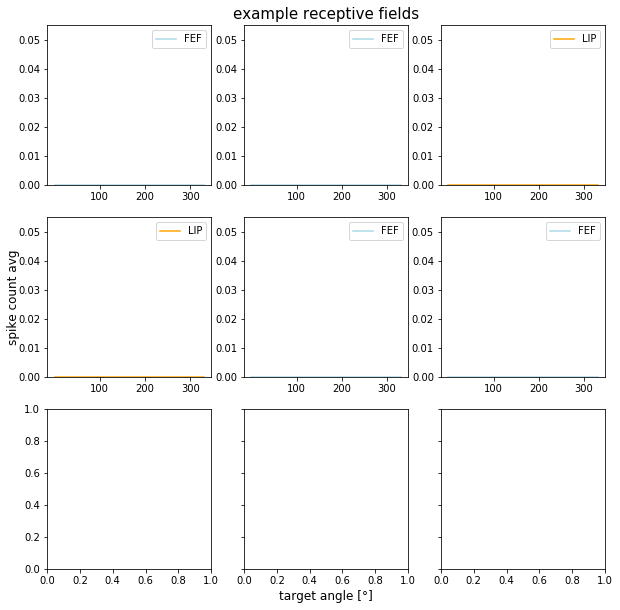

In [227]:
x = np.linspace(groups[0], groups[-1], len(groups))

num_neur = len(ROIs[sess_idx])
fig, ax = plt.subplots(int(num_neur/2), int(num_neur/2), sharex=True, sharey=True, figsize=(10,10))
for i in range(0,num_neur):
    shift=0
    plt.subplot(int(num_neur/2),int(num_neur/2),i+1)
    if ROIs[sess_idx][i]=='LIP':
        c = 'orange'
    else:
        c='lightblue'
    plt.plot(x,[receptive_fields[n][shift+i] for n in range(len(receptive_fields))], color=c, label=ROIs[sess_idx][i])
    plt.xticks([100,200,300],[100,200,300])
    plt.ylim(0, plt.ylim()[1])
    plt.legend()
    #plt.title('neuron '+str(shift+i))
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.title('example receptive fields', fontsize=15)
plt.xlabel('target angle [°]', fontsize=12)
plt.ylabel('spike count avg', fontsize=12)
#plt.savefig('../Figures/ExampleReceptiveFields_Sa0.png',dpi=100)
plt.show()

## Bin data

In [486]:
#only use Sa, sess0
df_Sa0 = df_dat.loc[(df_dat['monkey']=='a') & (df_dat['session']==0)]

# make spike trains into csr matrix for each trial
df_Sa0.loc[:,'n_mat'] = [csr_matrix(df_Sa0.loc[n,'sp_train']) for n in df_Sa0['sp_train'].index]

# determine border points between different time periods, until beginning of delay
bins = 50 # number of time bins of 50ms
timings = ['fix','targ_on','targ_off', 'go_cue']#,'saccade', 'reward', 'trial_end']# discrete timings
help = 0
borders=[]
for period in range(len(timings)):
    #help += int(min([(df_Sa0.loc[n, timings[period+1]]-df_Sa0.loc[n, timings[period]]) for n in range(len(df_Sa0))])/bins)
    #borders.append(help)
    borders.append(int(min(df_dat[timings[period]]/bins)))
print(borders)

# determine border points INDIVID trials between different time periods, for end of delay
timings2 = ['go_cue','saccade', 'reward', 'trial_end']
t_borders2 = ['delay_start','delay_end','saccade', 'reward', 'trial_end', 'end_start', 'end']#
borders2={'delay_start': [], 'delay_end': [], 'saccade': [], 'reward':[], 'trial_end':[], 'end_start':[], 'end':[]}##np.zeros((len(timings2)+1, len(df_Sa0)))
for i,m in enumerate(borders2.keys()):
    if i==0:
        #create shifted "start" of delay
        borders2[m] = [int(df_Sa0.loc[n,'go_cue']/bins)-(borders[-1]-np.sum(borders[:-1])) for n in df_Sa0.index]#
    elif i ==1:
        # delay end
        borders2[m] = [int(df_Sa0.loc[n,'go_cue']/bins) for n in df_Sa0.index]
        #np.array([int(df_Sa0.loc[n,timings2[0]]/bins)-(borders[-1]) for n in range(len(df_Sa0))])
    elif m =='end_start':
        # shifted "start" of trial end : complete end of trial - minimum(trial_end-reward)
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins)-int(min((df_Sa0.loc[:,'trial_end']-df_Sa0.loc[:,'reward'])/bins)) for n in df_Sa0.index]#
    elif m == 'end':
        borders2[m] = [int(df_Sa0.loc[n,'trial_end']/bins) for n in df_Sa0.index]
    else:
    # create end delay, saccade start, reward start, trial_end through using minimum distance between periods, adding to delay_end, saccade_end,..
        borders2[m] = np.array(borders2[t_borders2[i-1]]) + min([int((df_Sa0.loc[n,timings2[i-1]]-df_Sa0.loc[n,timings2[i-2]])/bins) for n in df_Sa0.index])
    #print(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]])/bins) for n in range(len(df_Sa0))]))
    #np.array(min([int((df_Sa0.loc[n,timings2[period]]- df_Sa0.loc[n,timings2[period-1]]))/bins for n in range(len(df_Sa0))]))

print(borders2)
# add shift between trial short end and trial long start
borders.append(borders[-1]+min(np.array(borders2['trial_end'])- np.array(borders2['delay_start'])))

/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/melanie/anaconda3/envs/brian2/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


[20, 20, 24, 40]
{'delay_start': [67, 71, 67, 70, 71, 67, 70, 68, 67, 68, 65, 68, 73, 67, 64, 70, 65, 70, 75, 74, 64, 68, 67, 66, 75, 72, 76, 66, 68, 96, 68, 66, 64, 68, 66, 71, 66, 66, 76, 71, 69, 69, 71, 71, 74, 68, 71, 66, 70, 82, 71, 66, 74, 71, 66, 67, 74, 74, 78, 73, 69, 67, 70, 75, 65, 71, 68, 113, 69, 74, 84, 73, 69, 78, 68, 80, 75, 70, 72, 72, 68, 77, 68, 83, 70, 74, 70, 69, 70, 68, 74, 65, 69, 68, 96, 99, 68, 86, 79, 65, 90, 70, 84, 69, 76, 73, 90, 64, 67, 73, 70, 94, 70, 81, 80, 69, 71, 79, 93, 109, 67, 65, 67, 77, 65, 70, 85, 68, 81, 94, 79, 67, 71, 70, 82, 71, 76, 65, 70, 67, 69, 78, 75, 67, 64, 66, 69, 67, 70, 72, 65, 65, 71, 67, 72, 80, 83, 77, 67, 72, 67, 66, 72, 68, 65, 80, 83, 71, 76, 70, 92, 83, 67, 70, 73, 68, 69, 76, 64, 70, 74, 69, 67, 68, 72, 71, 65, 71, 66, 65, 69, 68, 76, 69, 80, 71, 70, 69, 71, 76, 68, 79, 68, 72, 76, 64, 67, 73, 72, 69, 72, 70, 69, 73, 64, 67, 68, 67, 68, 70, 69, 75, 68, 65, 69, 73, 65, 70, 66, 69, 73, 67, 70, 68, 75, 66, 80, 66, 77, 69, 65, 

In [487]:
# create firing rate count in time binned spike data
bin_sp_trials=[]
period_spikes=[]
for trial in df_Sa0.index:# for all trials
    binned_spikes = []
    for period in range(len(timings[:-1])):# for all discrete timings
        for t in range(borders[period+1]-borders[period]): # for all time bins in discrete timings:           
            # sum the matrix of neurons at timings in bin
            binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,int(df_Sa0.loc[trial,timings[period]]+t*bins):int(df_Sa0.loc[trial,timings[period]]+t*bins+bins)].toarray(), axis=1))
        #print(t)
    #print(len(binned_spikes[0]))
    bin_sp_trials.append(binned_spikes)
    
bin_sp_trials_pastdelay=[]
period_spikes=[]
for idx, trial in enumerate(df_Sa0.index):# for all trials
    binned_spikes = []
    for period in range(len(borders2)-1):# for all discrete timings
        for t in range(borders2[t_borders2[period+1]][0]-borders2[t_borders2[period]][0]): # for number of time bins in discrete timings:           
            # sum the matrix of neurons at timings in bin
            binned_spikes.append(np.sum(df_Sa0.loc[trial, 'n_mat'][:,int(borders2[t_borders2[period]][idx]*bins+t*bins):int(borders2[t_borders2[period]][idx]*bins+t*bins+bins)].toarray(), axis=1))
        #print(t)
    #print(len(binned_spikes[0]))
    bin_sp_trials_pastdelay.append(binned_spikes)

bin_sp_complete = np.append(bin_sp_trials,bin_sp_trials_pastdelay, axis=1)


In [488]:
# create borders for indication in plot
borders_full=[]
borders_full = np.append(borders,borders[-1]+borders2['delay_end'][0]-borders2['delay_start'][0])
borders_full = np.append(borders_full,borders_full[-1]+borders2['saccade'][0]-borders2['delay_end'][0])
borders_full = np.append(borders_full,borders_full[-1]+borders2['reward'][0]-borders2['saccade'][0])
borders_full = np.append(borders_full,borders_full[-1]+borders2['trial_end'][0]-borders2['reward'][0])
borders_full = np.append(borders_full,borders_full[-1]+borders2['end'][0]-borders2['trial_end'][0])

borders_pastdelay = borders_full[len(borders):]

## Decoding

In [489]:
serial = {'trial_id':[], 'target_prev': [], 'targ_off_prev':[], 'go_cue_prev':[], 'response_prev': [], 'delay_prev': [],'bin_sp_prev':[], 'target_curr': [], 'targ_on_curr':[], 'response_curr': [], 'delay_curr': [], 'bin_sp_curr':[],  'monkey': []}
for trial,idx in enumerate(df_Sa0.index[:-1]):
    if ((df_Sa0['trial_id'][idx]+1) == (df_Sa0['trial_id'][idx+1])):
        serial['trial_id'].append(idx)
        serial['target_prev'].append(df_Sa0['targ_angle'][idx]*np.pi/180)
        serial['targ_off_prev'].append(round(df_Sa0['targ_off'][idx]*np.pi/180, 5))
        serial['go_cue_prev'].append(df_Sa0['go_cue'][idx])
        serial['response_prev'].append(round(df_Sa0['saccade_angle'][idx]*np.pi/180, 5))
        serial['delay_prev'].append(df_Sa0['go_cue'][idx]-df_dat['targ_off'][idx])
        serial['bin_sp_prev'].append(bin_sp_complete[trial])
        serial['target_curr'].append(df_Sa0['targ_angle'][idx+1]*np.pi/180)
        serial['targ_on_curr'].append(df_Sa0['targ_on'][idx+1])
        serial['response_curr'].append(round(df_Sa0['saccade_angle'][idx+1]*np.pi/180, 5))
        serial['delay_curr'].append(df_Sa0['go_cue'][idx+1]-df_Sa0['targ_off'][idx+1]) 
        serial['bin_sp_curr'].append(bin_sp_complete[trial+1])
        serial['monkey'].append(df_Sa0['monkey'][idx])
        
df_serial = pd.DataFrame(serial)



In [490]:
def decode_continuous_prev_cur(dataframe,y, mode):
    # y is fixed only X changes based on time in trial

    acc_prev = []
    std_prev = []
    acc_curr = []
    std_curr = []
    for delta_t_train in range(len(df_serial['bin_sp_prev'][df_serial['bin_sp_prev'].index[0]])):# for each period ['targ_on', 'targ_off', 'go_cue', 'saccade', 'reward']
        # create training dataset: columns=neurons, rows=trials for previous/current trials
        X_prev = pd.DataFrame([dataframe['bin_sp_prev'][n][delta_t_train] for n in dataframe['bin_sp_prev'].index])
        X_curr = pd.DataFrame([dataframe['bin_sp_curr'][n][delta_t_train] for n in dataframe['bin_sp_curr'].index])
        
        # Crossvalidation
        acc_crosscorr_prev=[]
        acc_crosscorr_curr=[]
        for k in range(0,10):# k=10 as in Barbosa2020
            #train test split
            rand_state = randint(0,10000)# to get the same split for previous, current
            X_train_prev ,X_test_prev ,y_train, y_test = train_test_split(X_prev, y, test_size = 0.20, random_state = rand_state)
            X_train_curr ,X_test_curr ,y_train, y_test = train_test_split(X_curr, y, test_size = 0.20, random_state = rand_state)
            
            # determine labels (sine, cosine)
            y_train_cos = np.cos(y_train)
            y_train_sin = np.sin(y_train)
            #y_test_cos = np.cos(y_test)

            # make linear regression fit for sine/cosine for prev/current trial
            model_prev_cos = LinearRegression().fit(X_train_prev, y_train_cos)
            model_prev_sin = LinearRegression().fit(X_train_prev, y_train_sin)
            model_curr_cos = LinearRegression().fit(X_train_curr, y_train_cos)
            model_curr_sin = LinearRegression().fit(X_train_curr, y_train_sin)

            # make predictions of models
            preds_prev_cos = model_prev_cos.predict(X_test_prev)
            preds_prev_sin = model_prev_sin.predict(X_test_prev)
            preds_curr_cos = model_curr_cos.predict(X_test_curr)
            preds_curr_sin = model_curr_sin.predict(X_test_curr)

            #preds_prev_cos[np.where(preds_prev_cos>1)]=1
            #preds_prev_cos[np.where(preds_prev_cos<-1)]=-1
            #preds_prev_sin[np.where(preds_prev_sin>1)]=1
            #preds_prev_sin[np.where(preds_prev_sin<-1)]=-1

            preds_prev = [math.atan2(preds_prev_sin[n],preds_prev_cos[n]) for n in range(len(preds_prev_sin))]
            preds_curr = [math.atan2(preds_curr_sin[n],preds_curr_cos[n]) for n in range(len(preds_prev_sin))]

            # R squared value
            if mode == 'r2':
                acc_crosscorr_prev.append(metrics.r2_score(preds_prev, y_test))
                acc_crosscorr_curr.append(metrics.r2_score(preds_curr, y_test))
            elif mode == 'MSE':
                #acc_crosscorr_prev.append(np.mean(abs(circdist(preds_prev, y_test))))
                #acc_crosscorr_curr.append(np.mean(abs(circdist(preds_curr, y_test))))
                acc_crosscorr_prev.append(np.mean(circdist(preds_prev, y_test)**2))
                acc_crosscorr_curr.append(np.mean(circdist(preds_curr, y_test)**2))
            else:
                print('Mode needs to be either:\n'+'r2 for evaluation with R² metric \n'+\
                      'or\nMSE for evaluation with mean-squared error.')
                return
            

        acc_prev.append(np.mean(acc_crosscorr_prev))
        std_prev.append(np.std(acc_crosscorr_prev))
        acc_curr.append(np.mean(acc_crosscorr_curr))
        std_curr.append(np.std(acc_crosscorr_curr))
    return acc_prev, std_prev, acc_curr, std_curr


In [491]:
def plot_reactivations(acc_bias_prev, std_bias_prev, acc_bias_curr, std_bias_curr, borders, borders_pastdelay, mode):#, baseline
    # plot only trained/tested in same time bin
    if mode =='MSE':
        acc_bias_prev = np.array(acc_bias_prev)*-1
        std_bias_prev = std_bias_prev
        acc_bias_curr = np.array(acc_bias_curr)*-1
        std_bias_curr = std_bias_curr
        #baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
        #baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
        #acc_bias_prev = 100-np.array(acc_bias_prev)*100/circdist(0, np.pi)[0]**2#np.pi
        #std_bias_prev = np.array(std_bias_prev)*100
        #acc_bias_curr = 100-np.array(acc_bias_curr)*100/circdist(0, np.pi)[0]**2#np.pi
        #std_bias_curr = np.array(std_bias_curr)*100
    elif mode=='r2':
        acc_bias_prev = acc_bias_prev
    else:
        print('Mode needs to be either:\n'+'r2 for evaluation with R² metric\n'+\
                      'or\nMSE for evaluation with mean-squared error.')
    
    # colors
    c_base = 'grey'
    c_acc = 'darkred'
    
    x = np.linspace(0,len(acc_bias_prev[:borders[-2]])*bins, len(acc_bias_prev[:borders[-2]]))
    x2 = np.linspace(-(borders_pastdelay[2]-borders[-2])*bins,(borders_pastdelay[3]-borders_pastdelay[2])*bins, len(acc_bias_prev[borders[-2]:borders[-1]]))
    x3 = np.linspace(-(len(acc_bias_prev[borders[-1]:]))*bins,0, len(acc_bias_prev[borders[-1]:]))
    x4 = np.linspace(0,len(acc_bias_prev[:borders[-3]])*bins, len(acc_bias_curr[:borders[-3]]))
    labels = np.array(['0', '$S_{n-1}$', '$SE_{n-1}$', '$D_{n-1}$', '$D_{n-1}$','$S_{n-1}$','$R_{n-1}$', '$E_{n-1}$'])
    labels_curr = np.array(['$0_n$', '$S_n$', '$SE_n$'])

    y_low=-1.1
    y_high = 0.8
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,sharey=True, figsize=(18,8))
    plt.subplots_adjust(wspace=0.05)
    ax1.plot(x,acc_bias_prev[:borders[-2]], color=c_acc)
    ax1.fill_between(x, acc_bias_prev[:borders[-2]]-0.5*np.array(std_bias_prev[:borders[-2]]), acc_bias_prev[:borders[-2]]+0.5*np.array(std_bias_prev[:borders[-2]]), color=c_acc, alpha=0.2)
    # plot baseline
  #  ax1.plot(x,baseline['acc_prev'][:borders[-2]], color=c_base)
  #  ax1.fill_between(x, baseline['acc_prev'][:borders[-2]]-0.5*np.array(baseline['std_prev'][:borders[-2]]), baseline['acc_prev'][:borders[-2]]+0.5*np.array(baseline['std_prev'][:borders[-2]]), color=c_base, alpha=0.2)
    #for period in range(len(borders)):
    #    ax1.axvline(borders[period]*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax1.set_xticks(bins*np.array(borders))
    #ax1.set_xticklabels(labels[:len(borders)], fontsize=12)
    #ax1.set_yticklabels(fontsize=12)
    ax1.set_xlabel('$start_{n-1}$ aligned [ms]', fontsize=14)
    if mode =='MSE':
        ax1.set_ylabel('inverted '+str(mode)+'² (k=10) [rad]', fontsize=14)#avg $r^2$ score
    else:
        ax1.set_ylabel(str(mode)+' (k=10)', fontsize=14)#avg $r^2$ score
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    ax2.plot(x2,acc_bias_prev[borders[-2]:borders[-1]], color=c_acc)
    ax2.fill_between(x2, acc_bias_prev[borders[-2]:borders[-1]]-0.5*np.array(std_bias_prev[borders[-2]:borders[-1]]), acc_bias_prev[borders[-2]:borders[-1]]+0.5*np.array(std_bias_prev[borders[-2]:borders[-1]]), color=c_acc, alpha=0.2)
    # plot baseline
    #ax2.plot(x2,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax2.fill_between(x2, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax2.set_xlabel('$report_{n-1}$ aligned [ms]', fontsize=14)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.set_ticks_position('bottom')

    ax3.plot(x3,acc_bias_prev[borders[-1]:], color=c_acc)
    ax3.fill_between(x3, acc_bias_prev[borders[-1]:]-0.5*np.array(std_bias_prev[borders[-1]:]), acc_bias_prev[borders[-1]:]+0.5*np.array(std_bias_prev[borders[-1]:]), color=c_acc, alpha=0.2)
    # plot baseline
    #ax3.plot(x3,baseline['acc_prev'][borders[-1]:], color=c_base)
    #ax3.fill_between(x3, baseline['acc_prev'][borders[-1]:]-0.5*np.array(baseline['std_prev'][borders[-1]:]), baseline['acc_prev'][borders[-1]:]+0.5*np.array(baseline['std_prev'][borders[-1]:]), color=c_base, alpha=0.2)
    #for period in range(len(borders_pastdelay)):
    #    ax2.axvline((borders_pastdelay[period]-borders[-1])*bins, *ax.get_xlim(), color='grey',dashes=[4,2])
    #ax2.set_xticks(bins*np.array(borders_pastdelay-borders[-1]))
    #ax2.set_xticklabels(labels[len(borders):], fontsize=12)
    #ax2.set_yticklabels(fontsize=12)
    ax3.set_xlabel('$end_{n-1}$ aligned [ms]', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.xaxis.set_ticks_position('bottom')

    
    ax4.plot(x4,acc_bias_curr[:borders[-3]], color=c_acc, label='acc')
    ax4.fill_between(x4, acc_bias_curr[:borders[-3]]-0.5*np.array(std_bias_curr[:borders[-3]]), acc_bias_curr[:borders[-3]]+0.5*np.array(std_bias_curr[:borders[-3]]), color=c_acc, alpha=0.2)
    # baseline
#    ax4.plot(x4,baseline['acc_curr'][:borders[-3]], color=c_base, label='baseline')
#    ax4.fill_between(x4, baseline['acc_curr'][:borders[-3]]-0.5*np.array(baseline['std_curr'][:borders[-3]]), baseline['acc_curr'][:borders[-3]]+0.5*np.array(baseline['std_curr'][:borders[-3]]), color=c_base, alpha=0.2)
    #for period in range(len(borders[:3])):
    #    ax3.axvline(borders[period]*bins, *ax.get_ylim(), color='grey',dashes=[4,2])
    #ax3.set_xticks(bins*np.array(borders[:3]))
    #ax3.set_xticklabels(labels_curr, fontsize=12)
    ax4.set_xlabel('$start_n$ aligned [ms]', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.xaxis.set_ticks_position('bottom')
    plt.legend()

    y0=ax2.get_ylim()[0]
    y1=ax2.get_ylim()[1]
    ax1.fill_between([borders[1]*bins, borders[2]*bins], y0, y1, color='red', alpha=0.2)
    ax2.fill_between([0, (borders_pastdelay[3]-borders_pastdelay[2])*bins], y0,y1, color='grey', alpha=0.2)
    ax4.fill_between([borders[1]*bins, borders[2]*bins], y0,y1, color='red', alpha=0.2)

    #plt.savefig('../Figures/Neural/SerialBias/hemifields/left/TemporalGeneralisation_sincos_MSE_LeftCONTRA_Sa0.png', dpi=100, transparent=True)
    plt.show()
    
#    if mode =='MSE':
#        baseline['acc_prev'] = np.array(baseline['acc_prev'])*-1
#        baseline['acc_curr'] = np.array(baseline['acc_curr'])*-1
    return

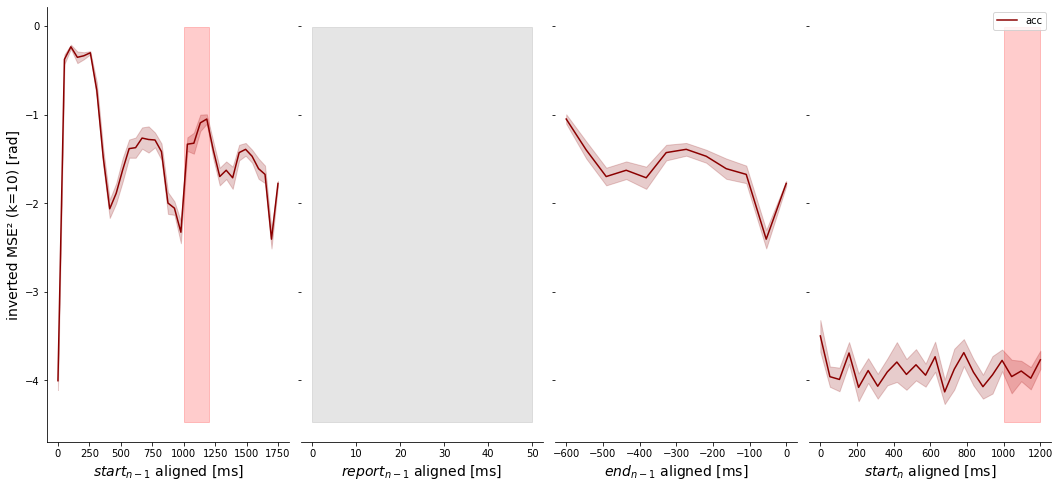

In [492]:
y_targ_prev = df_serial['target_prev'].values-np.pi# target_prev # response_prev

mode = 'MSE'#'r2'#'MSE'#

#baseline_file = "../Results/baselineAcc.txt"
#baseline = read_baseline(baseline_file, mode)

acc_bias_prev, std_bias_prev, acc_bias_curr, std_bias_curr = decode_continuous_prev_cur(df_serial,y_targ_prev, mode)#MSE
plot_reactivations(acc_bias_prev, std_bias_prev, acc_bias_curr, std_bias_curr, borders, borders_pastdelay, mode)#, baseline